# Sea Ice Zone Data Processing from CESM2 Hindcast
- Process data for Southern Ocean SIZ each year
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- June 2024

## SIZ is the maximum area covered by sea ice in each year

- Satellite observations show maximum sea ice extent in September but CESM2 has maximum in October (DuVivier et al. 2020, https://doi.org/10.1029/2019JC015934). So, we need to check which month to use for CESM2-LE or if we do a mean of both months.

In [1]:
import utils
import xarray as xr
import numpy as np
import pandas as pd
import dask
from distributed import Client
from ncar_jobqueue import NCARCluster
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## Spin up DASK cluster

In [2]:
# Create our NCAR Cluster - which uses PBSCluster under the hood
cluster = NCARCluster(walltime='2:00:00', cores=1, processes=1, memory='100 GB', 
                      resource_spec='select=1:ncpus=1:mem=100GB',interface='ext')

# Spin up 32 workers
cluster.scale(32)

# Assign the cluster to our Client
client = Client(cluster)

In [3]:
client
# cluster.close()

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.59:42291,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Read in grid data

In [4]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [5]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [6]:
# load sea ice masks
fin = 'REGION_MASK_gx1v7.nc'
ds_mask = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_mask = ds_mask.isel(time=0)
ds_mask = ds_mask.rename({'lat':'nlat','lon': 'nlon'})
ds_mask['nlat'] = ds_grid.nlat
ds_mask['nlon'] = ds_grid.nlon
ds_mask

<xarray.Dataset>
Dimensions:       (nlon: 320, nlat: 384)
Coordinates:
  * nlon          (nlon) int64 0 1 2 3 4 5 6 7 ... 313 314 315 316 317 318 319
  * nlat          (nlat) int64 0 1 2 3 4 5 6 7 ... 377 378 379 380 381 382 383
Data variables: (12/18)
    Lab_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    GIN_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Bar_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ArcOc_mask    (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Sib_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Beau_mask     (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...            ...
    Ross_mask     (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Ind_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Pac_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    BAm_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    nh_mask       (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    sh_mask       (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>

In [7]:
# crop data to just the southern hemisphere below 60S
ds_grid = ds_grid.isel(nlat=slice(0,36))
ds_mask = ds_mask.isel(nlat=slice(0,36))

## Read in Hindcast data

In [8]:
## Enter variable of interest
var_in = 'aice'

## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [9]:
dir_in = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch/ice/proc/tseries/month_1/'
file_in = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch.cice.h.'+var_in+'.195801-202112.nc'
ds = xr.open_mfdataset(dir_in+file_in,decode_times=False)

In [10]:
# keep only some variables
keep_vars=['z_t','time_bound','z_t_150m','KMT','TLAT','TLONG','time',var_in]
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

In [11]:
# crop to southern ocean only
#ds = ds.isel(nlat=slice(0,36))
ds = ds.where(((ds['TLAT'] <= lat_max) & (ds['TLAT'] >= lat_min)), drop=True)

In [12]:
# check time array
ds.time

<xarray.DataArray 'time' (time: 768)>
array([714336., 714364., 714395., ..., 737604., 737634., 737665.])
Coordinates:
  * time     (time) float64 7.143e+05 7.144e+05 ... 7.376e+05 7.377e+05
Attributes:
    long_name:     model time
    units:         days since 0001-01-01 00:00:00
    calendar:      noleap
    bounds:        time_bounds
    cell_methods:  time: mean

In [13]:
# to make useable time coordinate, create arrays for yyyy-mm-dd (NO LEAP!)
# We know it's monthly data for 1958.01-2021.12, not including leap days.

# create full range of dates at daily frequency
dates = pd.date_range(start='1/1/1958', end='12/31/2021', freq='M')
# check that the # times matches above
print(dates.shape)

(768,)


In [14]:
# assign the new time array
ds['time'] = dates

# Compute Annual Maximum SIE
* Maximum extent is either in September or October

In [15]:
yy_st = 1958
yy_ed = 2021

In [16]:
# get some sizes
years = np.arange(int(yy_st),int(yy_ed),1)

tlen = len(years) 
xlen = len(ds.ni)
ylen = len(ds.nj)
print(tlen,xlen,ylen)

63 320 36


### Get the September and October sea ice

In [17]:
%%time

ds_Sep = xr.Dataset()
Sep = np.zeros([tlen,ylen,xlen])

ds_Oct = xr.Dataset()
Oct = np.zeros([tlen,ylen,xlen])

ds_Sep_Oct = xr.Dataset()
Sep_Oct = np.zeros([tlen,ylen,xlen])

for year in np.arange(0,tlen,1):

    # September
    #get time index of september for this year
    st_mon_sep = year*12 + 8
    #get that month only
    Sep[year,:,:] = ds[var_in].isel(time=st_mon_sep)

    # October
    #get time index of september for this year
    st_mon_oct = year*12 + 9
    #get that month only
    Oct[year,:,:] = ds[var_in].isel(time=st_mon_oct)

    # Sept and Oct mean
    #get those months only
    temp = ds[var_in].isel(time=slice(st_mon_sep,st_mon_oct+1))
    Sep_Oct[year,:,:] = temp.mean(dim='time')

CPU times: user 12.9 s, sys: 1.89 s, total: 14.7 s
Wall time: 7min 55s


In [18]:
# turn into xarrays
Sep = xr.DataArray(Sep,dims=('time','nlat','nlon'))
ds_Sep[var_in] = Sep
ds_Sep[var_in].attrs['units'] = ''
ds_Sep['time'] = years

Oct = xr.DataArray(Oct,dims=('time','nlat','nlon'))
ds_Oct[var_in] = Oct
ds_Oct[var_in].attrs['units'] = ''
ds_Oct['time'] = years

Sep_Oct = xr.DataArray(Sep_Oct,dims=('time','nlat','nlon'))
ds_Sep_Oct[var_in] = Sep_Oct
ds_Sep_Oct[var_in].attrs['units'] = ''
ds_Sep_Oct['time'] = years

### Calculate the SIA each year

In [19]:
# keep only regions with >15% ice cover
ds_Sep_mask = ds_Sep.where(ds_Sep.aice > 0.15)
ds_Oct_mask = ds_Oct.where(ds_Oct.aice > 0.15)
ds_Sep_Oct_mask = ds_Sep_Oct.where(ds_Sep_Oct.aice > 0.15)

In [20]:
ds_Sep_mask['time'] = years
ds_Oct_mask['time'] = years
ds_Sep_Oct_mask['time'] = years

In [21]:
# multipy by tarea
tarea = ds_grid.TAREA

ds_Sep_mask = ds_Sep_mask*tarea
ds_Oct_mask = ds_Oct_mask*tarea
ds_Sep_Oct_mask = ds_Sep_Oct_mask*tarea

In [22]:
# sum over all lat/lon points
ds_Sep_sum = ds_Sep_mask.aice.sum(dim=['nlat','nlon'])
ds_Oct_sum = ds_Oct_mask.aice.sum(dim=['nlat','nlon'])
ds_Sep_Oct_sum = ds_Sep_Oct_mask.aice.sum(dim=['nlat','nlon'])

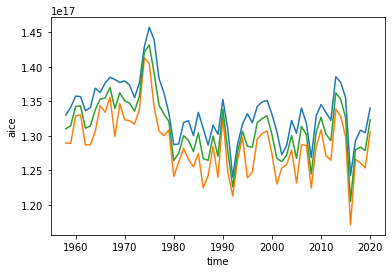

In [23]:
ds_Sep_sum.plot()
ds_Oct_sum.plot()
ds_Sep_Oct_sum.plot()

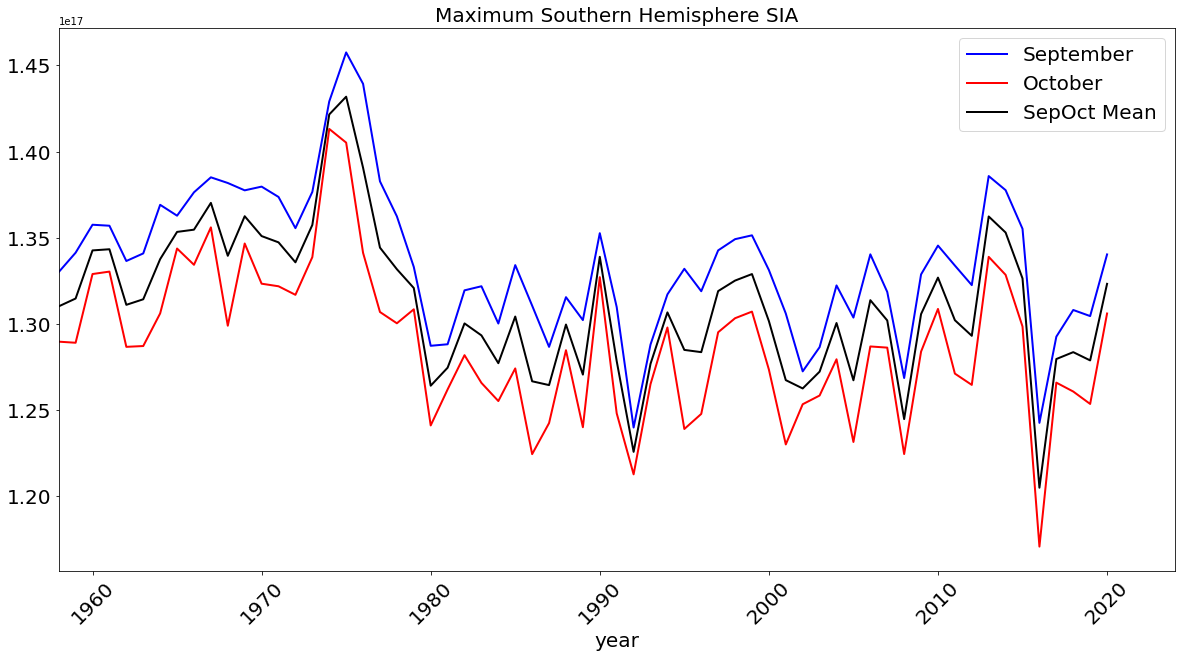

In [24]:
# Make nicer plot with labels

# create figure
fig = plt.figure(figsize=(20,10))

# Make subplot - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1) 

# plot the Sep values
ax.plot(years,ds_Sep_sum,label="September",color='blue',linestyle='solid',linewidth=2)
# plot the Oct values
ax.plot(years,ds_Oct_sum,label="October",color='red',linestyle='solid',linewidth=2)
# plot the mean Sep/Oct values
ax.plot(years,ds_Sep_Oct_sum,label="SepOct Mean",color='black',linestyle='solid',linewidth=2)

# finish up plot
plt.title('Maximum Southern Hemisphere SIA',fontsize=20)
plt.xlabel('year',fontsize=20)
plt.xticks(fontsize=20, rotation=45)
plt.xlim([1958,2024])
plt.yticks(fontsize=20)
plt.legend(ncol=1,fontsize=20)


- Satellite observations show maximum sea ice extent in September, but past work showed CESM2 maximum in October (DuVivier et al. 2020, https://doi.org/10.1029/2019JC015934).
- The above figures show that in the CESM2-LE the September sea ice area is greater than the October sea ice area. Time indices have been checked to verify we're pulling the correct months.
- This result is contrary to the DuVivier 2020 paper, but does match observations better.
- Therefore, for calculation of yearly SIZ we will use CESM2 Hindcast September sea ice concentrations.

## Calculate SIZ

In [25]:
# set some coordinates for the sea ice so we can do the masking
ds_Sep['nlat'] = ds_mask.nlat
ds_Sep['nlon'] = ds_mask.nlon

In [26]:
# create a mask using the 0-1 array from sh_mask and where SIC is above 15%
SIZ_mask = ds_mask.sh_mask.where(ds_Sep.aice >= 0.15,0)

# mask everything south of 65S since that will all be sea ice too and we don't want polynyas to show up as well
SIZ_mask = SIZ_mask.where(ds_grid.TLAT >= -65.0, 1)

# omit land points
SIZ_mask = SIZ_mask.where(ds_grid.REGION_MASK == 1)

SIZ_mask

<xarray.DataArray 'sh_mask' (nlat: 36, nlon: 320, time: 63)>
dask.array<where, shape=(36, 320, 63), dtype=float32, chunksize=(36, 320, 63), chunktype=numpy.ndarray>
Coordinates:
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
  * time     (time) int64 1958 1959 1960 1961 1962 ... 2016 2017 2018 2019 2020
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>

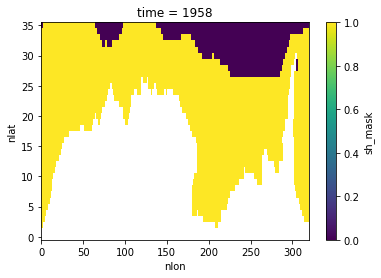

In [27]:
SIZ_mask.isel(time=0).plot()

## Put together into one dataset

- Netcdf with variable dimension: (year x nlat x nlon)
- Include TAREA, andd TLAT and TLONG as coordinates

In [28]:
ds_out = xr.Dataset()

ds_out['SIZ_SEP'] = SIZ_mask
ds_out['SIZ_SEP'].attrs['units'] = 'unitless'
ds_out['SIZ_SEP'].attrs['long_name'] = 'Sea ice zone from maximum september extent'
ds_out['TAREA'] = ds_grid.TAREA

# add global attributes
ds_out.attrs['author'] = 'Alice DuVivier'
ds_out.attrs['date_processed'] = datetime.now().strftime('%Y-%m-%d')
ds_out.attrs['contents'] = f'yearly SIZ in the Southern Ocean from 1958 to 2020 from CESM2 ice/ocean hindcast forced with JRA55.'

ds_out

<xarray.Dataset>
Dimensions:  (nlon: 320, nlat: 36, time: 63)
Coordinates:
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
  * time     (time) int64 1958 1959 1960 1961 1962 ... 2016 2017 2018 2019 2020
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
Data variables:
    SIZ_SEP  (nlat, nlon, time) float32 dask.array<chunksize=(36, 320, 63), meta=np.ndarray>
    TAREA    (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
Attributes:
    author:          Alice DuVivier
    date_processed:  2024-06-20
    contents:        yearly SIZ in the Southern Ocean from 1958 to 2020 from ...

In [29]:
# drop the ULAT/ULONG variables
ds_out = ds_out.drop('ULAT')
ds_out = ds_out.drop('ULONG')

In [30]:
# Print the dimensions
print("Dimensions:")
for dim in ds_out.dims:
    print(f"\t{dim}: {ds_out[dim].values.shape}")

# Print the coordinates
print("Coordinates:")
for coord in ds_out.coords:
    print(f"\t{coord}:")
    print(f"\t\t{ds_out.coords[coord].values}")
    
# Print the attributes
print("Attributes:")
for attr in ds_out.attrs:
    print(f"\t{attr}: {ds_out.attrs[attr]}")
    

Dimensions:
	nlon: (320,)
	nlat: (36,)
	time: (63,)
Coordinates:
	nlon:
		[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 2

## Export and Save

In [31]:
# calculate the size of the dataset in GB
size_gb = ds_out.nbytes / (1024**3)
print(f"The dataset is approximately {size_gb:.2f} GB.")


The dataset is approximately 0.00 GB.


In [32]:
path_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/sea_ice/'
file_out = 'CESM2-JRA55-hindcast-SIZ.nc'
fout = path_out + file_out

In [33]:
# Export the dataset to NetCDF with all attributes and coordinates
ds_out.to_netcdf(fout)

In [34]:
cluster.close()

tornado.application - ERROR - Exception in callback functools.partial(<function TCPServer._handle_connection.<locals>.<lambda> at 0x14c2405cc9e0>, <Task finished coro=<BaseTCPListener._handle_stream() done, defined at /glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/distributed/comm/tcp.py:502> exception=ValueError('invalid operation on non-started TCPListener')>)
Traceback (most recent call last):
  File "/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/tornado/tcpserver.py", line 331, in <lambda>
    gen.convert_yielded(future), lambda f: f.result()
  File "/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/distributed/comm/tcp.py", line 508, in _handle_stream
    logger.debug("Incoming connection from %r to %r", address, self.contact_address)
  File "/glade/wo